In [9]:
import numpy as np
import torch
import pandas as pd
from collections import deque
!pip install ucimlrepo  --quiet

In [10]:
from ucimlrepo import fetch_ucirepo

# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets
# metadata 
metadata = predict_students_dropout_and_academic_success.metadata

# variable information 
variable_info = predict_students_dropout_and_academic_success.variables

df = X
df['Target'] = y

print(f"{df.shape[0]} entries with {df.shape[1]} features")

4424 entries with 37 features


In [11]:
categorical_vars = {
    'Marital Status',
    'Application mode',
    'Course',
    'Daytime/evening attendance',
    'Previous qualification',
    'Nacionality',
    'Mother\'s qualification',
    'Father\'s qualification',
    'Mother\'s occupation',
    'Father\'s occupation',
    'Displaced', 'Educational special needs', 'Debtor',
    'Tuition fees up to date', 'Gender', 'Scholarship holder',
    'International',
    'Target'
}
quantitative_vars = {
   'Application order',
    'Previous qualification (grade)',
    'Admission grade',
    'Age at enrollment',
   'Curricular units 1st sem (enrolled)',
   'Curricular units 1st sem (credited)',
   'Curricular units 1st sem (evaluations)',
   'Curricular units 1st sem (approved)',
   'Curricular units 1st sem (grade)',
   'Curricular units 1st sem (without evaluations)',
   'Curricular units 2nd sem (credited)',
   'Curricular units 2nd sem (enrolled)',
   'Curricular units 2nd sem (evaluations)',
   'Curricular units 2nd sem (approved)',
   'Curricular units 2nd sem (grade)',
   'Curricular units 2nd sem (without evaluations)',
   'Unemployment rate',
   'Inflation rate',
    'GDP'
}
print("categorical vars", len(categorical_vars))
print("quantitative vars", len(quantitative_vars))


categorical vars 18
quantitative vars 19


In [12]:

df.columns

Index(['Marital Status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

In [13]:
# remove the 'enrolled' column from dataframe:
df.drop(['Inflation rate', 'GDP'], axis=1, inplace=True)
misc_curriculum = [
    "Curricular units 1st sem (evaluations)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 1st sem (credited)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (without evaluations)",
]
quantitative_vars -= set(misc_curriculum).union({"Inflation rate", "GDP"})
df.drop(misc_curriculum, axis=1, inplace=True)

df_encoded = df[df['Target'].isin(['Graduate', 'Dropout'])].copy()
df_encoded["Target"] = df_encoded["Target"].replace({'Graduate': 0, 'Dropout': 1})
# Applying one-hot encoding on categorical variables
df_encoded = pd.get_dummies(df_encoded, columns=list(categorical_vars - {'Target'}))

# normalize quantitative columns:
df_encoded[list(quantitative_vars)] = df_encoded[list(quantitative_vars)].apply(lambda x: (x-x.min())/(x.max()-x.min()))

valid_count = int(len(df_encoded) * 0.7)
test_count = int(len(df_encoded) * 0.8)
df_shuffled = df_encoded.sample(frac=1, random_state=42).reset_index(drop=True)
df_train = df_encoded[:valid_count].reset_index(drop=True)
df_valid = df_encoded[valid_count:test_count].reset_index(drop=True)
df_test = df_encoded[test_count:].reset_index(drop=True)

y_train = df_train["Target"]
x_train = df_train.drop(["Target"], axis=1)

y_test = df_test["Target"]
x_test = df_test.drop(["Target"], axis=1)

y_valid = df_valid["Target"]
x_valid = df_valid.drop(["Target"], axis=1)

print(f"train_ds: {df_train.shape[0]} samples")
print(f"test_ds: {df_test.shape[0]} samples")
print(f'[train_ds]: input shape: {x_train.shape}, output shape: {y_train.shape}')
print(f'[valid_ds]: input shape: {x_valid.shape}, valid shape: {y_valid.shape}')
print(f'[test_ds]: input shape: {x_test.shape}, output shape: {y_test.shape}')


train_ds: 2541 samples
test_ds: 726 samples
[train_ds]: input shape: (2541, 238), output shape: (2541,)
[valid_ds]: input shape: (363, 238), valid shape: (363,)
[test_ds]: input shape: (726, 238), output shape: (726,)


In [14]:
from torch.utils.data import Dataset, DataLoader
class DropoutDS(Dataset):
    def __init__(self, x,y):
        self.input_df = x
        self.output_df = y

    def __len__(self):
        return self.input_df.shape[0]

    def __getitem__(self, idx):
        inp = self.input_df.iloc[idx].astype(float)
        out = np.expand_dims(self.output_df.iloc[idx].astype(float), axis=0)
        # out = self.output_df.iloc[idx].astype(float)
        inp_t = torch.tensor(inp.values, dtype=torch.float32)
        out_t = torch.tensor(out, dtype=torch.float32)
        return inp_t, out_t

batch_size = 10
train_dl = DataLoader(DropoutDS(x_train, y_train), batch_size=batch_size, shuffle=True)
test_dl = DataLoader(DropoutDS(x_test, y_test), batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(DropoutDS(x_valid, y_valid), batch_size=batch_size, shuffle=True)
# testing dl size
x, y= next(iter(train_dl))
print(x.shape, y.shape)



torch.Size([10, 238]) torch.Size([10, 1])


In [15]:
import torch.nn as nn
dropout_prob = 0.25

model = nn.Sequential(
    nn.Linear(238, 256),
    nn.ReLU(),
    nn.Dropout(p=dropout_prob),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=dropout_prob),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=dropout_prob),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(p=dropout_prob),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)

def init_model_weights(model):
    if isinstance(model, nn.Linear):
        nn.init.normal_(model.weight, mean=0, std=0.1)
        nn.init.constant_(model.bias, 0)

model.apply(init_model_weights)
print(f"{sum(p.numel() for p in model.parameters())} trainable params")


105089 trainable params


In [16]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def get_mis_cls(outputs, tgt):
    cls = torch.round(outputs).type(torch.int32)
    tgt = tgt.type(torch.int32)
    mis_cls = torch.sum(torch.abs(cls - tgt))
    return mis_cls.item()
    

def valid_epoch(dl):
    model.train(False)
    running_loss = 0.
    total_mis_cls = 0
    with torch.no_grad():
        for i, data in enumerate(dl):
            inputs, tgt = data

            outputs = model(inputs)
            
            loss = loss_fn(outputs, tgt)
            running_loss += loss.item()
            total_mis_cls += get_mis_cls(outputs, tgt)
    return running_loss/len(dl), 1 - float(total_mis_cls) / (len(dl) * batch_size)

def train_epoch():
    model.train(True)
    running_loss = 0.
    total_mis_cls = 0
    for i, data in enumerate(train_dl):
        inputs, tgt = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, tgt)
        total_mis_cls += get_mis_cls(outputs, tgt)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss/len(train_dl), 1 - float(total_mis_cls) / x_train.shape[0]

EPOCHS = 200
loss = []
all_train_acc = []
all_valid_acc = []
all_valid_loss = []
all_train_loss = []
acc_queue = deque()
max_acc = -1e10
best_performance = 0,0
count_avg_perf = 5
for epoch in range(EPOCHS):
    avg_train_loss, train_acc = train_epoch()
    avg_valid_loss, valid_acc = valid_epoch(valid_dl)
    all_train_loss.append(avg_train_loss)
    all_valid_loss.append(avg_valid_loss)
    all_train_acc.append(train_acc)
    all_valid_acc.append(valid_acc)
    if len(acc_queue) > count_avg_perf:
        acc_queue.popleft()
    acc_queue.append(valid_acc)
    curr_max_acc = sum(list(acc_queue)) / float(count_avg_perf)
    if curr_max_acc > max_acc:
        max_acc =  curr_max_acc
        best_performance = (train_acc, valid_acc, avg_train_loss, avg_valid_loss)
        max_acc_epoch = epoch
        torch.save(model, 'mlp-model.pt')
    print(f'epoch: {epoch} | train_loss: {avg_train_loss:.2f} valid_loss: {avg_valid_loss:.2f}'
          f'| train_acc: {train_acc:.4f} | valid_acc: {valid_acc:.4f}', end= '\r')
print(f'\nBest Model Performance:\n\ttrain_acc: {best_performance[0]:.4f}\n\tvalid_acc: {best_performance[1]:.4f}')
print(f'\nBest Model Performance:\n\ttrain_loss: {best_performance[2]:.4f}\n\tvalid_loss: {best_performance[3]:.4f}')


epoch: 199 | train_loss: 0.04 valid_loss: 0.83| train_acc: 0.9835 | valid_acc: 0.8784
Best Model Performance:
	train_acc: 0.9366
	valid_acc: 0.9027

Best Model Performance:
	train_loss: 0.1669
	valid_loss: 0.3748


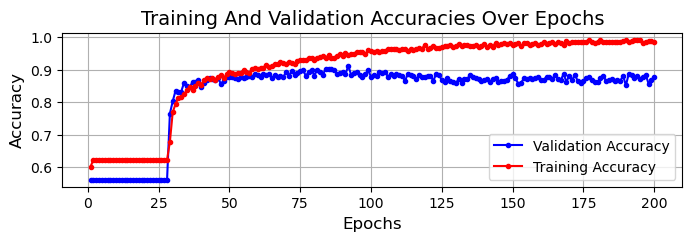

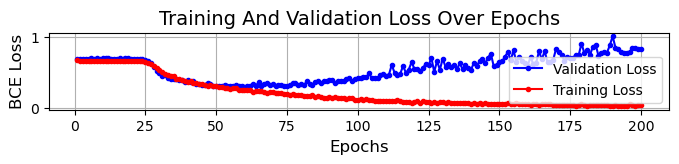

In [32]:
import matplotlib.pyplot as plt

epochs = np.arange(1, EPOCHS + 1)
# PLOT ACCURACIES
plt.figure(figsize=(8,2))
plt.plot(epochs, all_valid_acc, marker='.', color='b', label='Validation Accuracy')
plt.plot(epochs, all_train_acc, marker='.', color='r', label='Training Accuracy')
plt.title('Training And Validation Accuracies Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

plt.figure(figsize=(8,1))
plt.plot(epochs, all_valid_loss, marker='.', color='b', label='Validation Loss')
plt.plot(epochs, all_train_loss, marker='.', color='r', label='Training Loss')
plt.title('Training And Validation Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('BCE Loss', fontsize=12)

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [25]:
# evaluating on test dataset:
model = torch.load('mlp-model.pt')
avg_test_loss, test_acc = valid_epoch(test_dl)

In [22]:
avg_test_loss, test_acc

(0.3647885884171071, 0.8726027397260274)